# Make predictions with a CNN and evaluate performance

In this notebook, we use a CNN to recognize bird localizations in audio recordings. We evaluate the CNN's accuracy and visualize the activation of the CNN on a spectrogram.  

This notebook uses the CNN trained in Notebook 02. The trained model file is included in the repository so that this notebook can be run without running Notebook 02 to train the model. 

In [48]:
import pandas as pd
from opensoundscape import CNN, Audio

%config InlineBackend.figure_format = 'retina'

In [24]:
# Load model trained in Notebook 02:
model = CNN.from_torch_dict('./resources/03/saved_cnn.model_dict')

## Use the model to predict on the test set
Again, this step can take a while depending on the speed of your computer. To skip this step and load the table of scores generated by the CNN, uncomment and run the subsequent cell instead of the one below:

In [26]:
#load the table listing files in the test set 
# (these files were excluded from training and validation)
test_set = pd.read_csv("./resources/03/test_set.csv",index_col=[0,1,2])

# subset the labels to only those the model was trained on
test_set = test_set[model.classes]

# run "inference": use the CNN to predict the presence of each class in the audio clips
predictions = model.predict(test_set)

In [30]:
# # uncomment this cell to load the scores from a saved table instead of running the cell above
# predictions = pd.read_csv('./resources/03/cnn_predictions_test_set.csv',index_col=[0,1,2])

The table of predictions has a score for each class for each 3-second audio segment. 

In [29]:
predictions.head(2)

NOCA  \
file                                               start_time end_time             
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -3.724006   
                                                   3.0        6.0      -6.776401   

                                                                            EATO  \
file                                               start_time end_time             
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -3.340631   
                                                   3.0        6.0       1.162202   

                                                                            SCTA  \
file                                               start_time end_time             
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -6.241127   
                                                   3.0        6.0      -5.377924   

                                                                            BAWW  \
file                                               start_time end_time             
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -3.257714   
                                                   3.0        6.0      -5.708066   

                                                                            BCCH  \
file                                               start_time end_time             
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -0.565048   
                                                   3.0        6.0       0.167230   

                                                                            AMCR  \
file                                               start_time end_time             
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -0.596059   
                                                   3.0        6.0      -8.136910   

                                                                            NOFL  
file                                               start_time end_time            
/Users/SML161/demos-for-opso/ecy3329-sup-0001-d... 0.0        3.0      -1.927623  
                                                   3.0        6.0      -7.890665

## Visualize the model's attention to specific classes in a sample
The second clip in the test set contains an Eastern Towhee (EATO). Let's see what the model is paying attention to as it generates a score for that class. 

We'll use GradCAM (gradient class activation maps) to visualize the parts of a sample that are activated when the model predicts that the sample contains an Eastern Towhee vocalization.

In [31]:
# generate AudioSample objects with GradCAM maps
samples = model.generate_cams(samples=test_set.head(4),classes=['EATO'],guided_backprop=True) 

sample without a mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


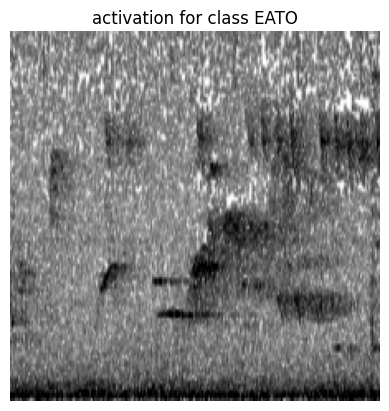

<Audio(samples=(132300,), sample_rate=44100)>

In [43]:
sample = samples[3]
_=sample.cam.plot(target_class='EATO',alpha=0)
Audio.from_file(sample.source,offset=sample.start_time,duration=sample.duration) #display audio widget

Visualize the GradCAM heatmap on Layer4 of the ResNet architecture

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


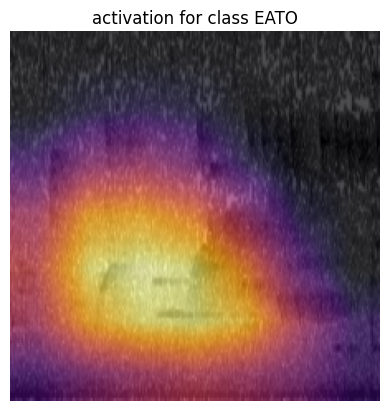

In [44]:
_=sample.cam.plot(target_class='EATO',alpha=0.7)

Show the activated pixels from the original sample with guided backpropagation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


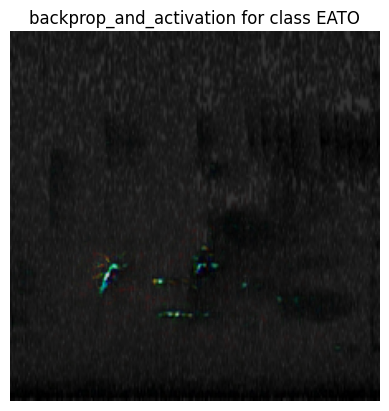

In [45]:
_=sample.cam.plot(target_class='EATO',alpha=0.8,mode='backprop_and_activation')

Great, this shows that the CNN is paying attention to the regions in the spectrogram that contain Eastern Towhee vocalizations, which led it to correctly predict the presence of Eastern Towhee in this sample. 

Interestingly, the CNN picks up on both the "scree" call  and the early parts of the song. Because we haven't trained the CNN with separate classes for songs and calls, it does not differentiate between vocalization types, and considers all to be part of the "EATO" class. 

## Plot the histograms for score distributions
We can validate the model's perfomance by plotting histograms of the scores outputted by the model on our test set. 

If a classifier performs well, it will give high scores to the positives (audio clips containing the species of interest) and lower scores to the negatives (audio clips that do not contain the species of interest). 

This classifier works well for some species, and has failed to learn others. Its performance would likely improve if we trained it with more data or adjusted training parameters. It could already be used to save a lot of listening effort if used for 'top-down listening' to confirm presence of a species at a site. Top-down listening is a process where audio clips are listened to by experts to verify presence at a site, starting with the highest scoring files and listening 'down' to lower scoring clips if necessary.

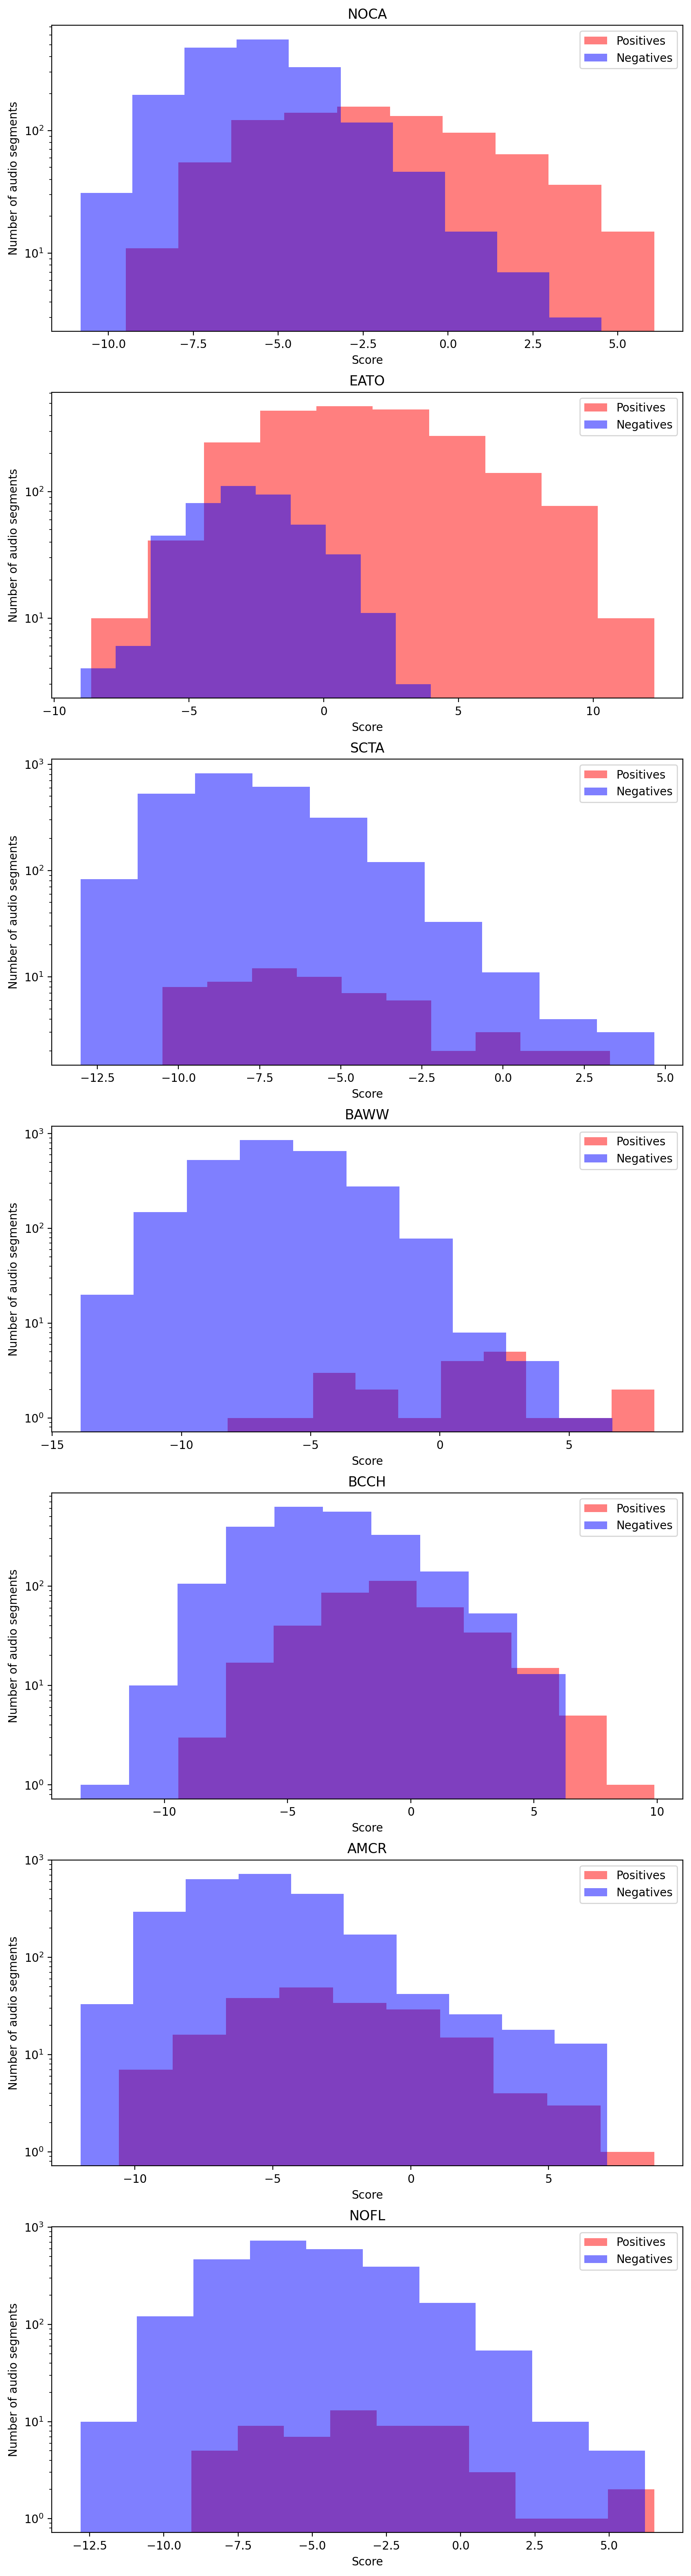

In [49]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(7,1, figsize = (10,40))
axs = np.ravel(axs)
for ax, species in enumerate(model.classes):
    positives = test_set[species] == 1
    negatives = test_set[species] == 0
    axs[ax].hist(predictions.loc[positives][species], alpha=0.5, color="red", label="Positives")
    axs[ax].hist(predictions.loc[negatives][species], alpha=0.5, color="blue", label="Negatives")
    axs[ax].set_yscale("log")
    axs[ax].title.set_text(species)
    axs[ax].set_ylabel("Number of audio segments")
    axs[ax].set_xlabel("Score")
    axs[ax].legend()